<a id="topV"></a>

# Viewing COS Data

# Learning Goals
### This Notebook is designed to walk the user (*you*) through:
#### 1. **[Reading in the data](#readInV) using `Python`**
#### 2. **[Displaying the data](#plottingV) using common plotting techniques**

# 0. Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope ([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).

#### This tutorial aims to prepare you to begin analyzing COS data of your choice by walking you through reading and viewing a spectrum obtained with COS, as well as obtaining a few diagnostic measurements of your spectrum.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).


## We will import the following packages:

- numpy to handle array functions
- astropy.io fits for accessing FITS files
- astropy.table Table for creating tidy tables of the data
- astropy.units and astropy.visualization.quantity_support for dealing with units
- matplotlib.pyplot for plotting data
- astroquery.mast Mast and Observations for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive

In [1]:
#Make matplotlib look good in a notebook
%matplotlib inline
# Manipulating arrays
import numpy as np
# Reading in data
from astropy.io import fits
from astropy.table import Table
# Dealing with units and plotting them
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
# Plotting
import matplotlib.pyplot as plt
# Downloading data from archive
from astroquery.mast import Mast
from astroquery.mast import Observations
from astroquery.mast import Catalogs


## We will also define a few directories in which to place our data and plots, as well as a few colors we will use in plots later.

In [2]:
# These will be important directories for the notebook
cwd = !pwd
cwd = cwd[0]

datadir = cwd + '/data/'
outputsdir = cwd + '/output/'
plotsdir = cwd + '/output/plots/'

# A few colors for plotting - feel free to change these!
segment_colors = {'FUVA':'#BC8C5B', 'FUVB':'#4B6CA4', 'NUVA':'#1813CE','NUVB':'#61946E','NUVC':'#8C1A11'}

## We will be working with some FUV and NUV datasets downloaded in the cell below. Searching for and downloading data is out of the scope of this tutorial. If you wish to learn more, please see our [tutorial on downloading COS data](#NEEDSLINK!)

In [3]:
nuv_downloads = Observations.download_products(Observations.get_product_list(Observations.query_criteria(obs_id = 'lbbd01020')), # GET the NUV data on WD1057+719 with the G230L grating; only the _x1dsum and _asn
                                           download_dir=datadir , extension='fits', mrp_only=True, cache=False)

fuv_downloads = Observations.download_products(Observations.get_product_list(Observations.query_criteria(obs_id = 'lcxv13050')), # GET the NUV data on WD1057+719 with the G230L grating; only the _x1dsum and _asn
                                           download_dir=datadir , extension='fits', mrp_only=True, cache=False)


<a id="readInV"></a>
# 1. Reading in the data

The calibrated spectrum data is now on our local machine as: **`current-working-directory`**`/data/mastDownload/HST/`**`Obs_id`**`/`**`Obs_id`**`_x1dsum.fits`,
where the NUV and FUV Data are contained in the obs_ids:

| Spectral Region | Obs_id|filepath|
|-----|------------|-|
| FUV | LBBD01020|   ./data/mastDownload/HST/lbbd01020|
| NUV | LCXV13050|   ./data/mastDownload/HST/lcxv13050|

## 1.1. Investigating the Data - *Basics*
We want to learn a bit about this file, then input the data.

We can learn a great deal about our data from its primary fits header (see cell below).

In [4]:
fuv_x1d_filepath = './data/mastDownload/HST/lcxv13050/lcxv13050_x1dsum.fits' # Make sure these point to your new FUV data!
fuv_asn_filepath = './data/mastDownload/HST/lcxv13050/lcxv13050_asn.fits'    # This is the association file

nuv_x1d_filepath = './data/mastDownload/HST/lbbd01020/lbbd01020_x1dsum.fits' # Make sure these point to your new NUV data!
nuv_asn_filepath = './data/mastDownload/HST/lbbd01020/lbbd01020_asn.fits'    # This is the association file


nuv_header_x1d = fits.getheader(nuv_x1d_filepath)
nuv_header_asn = fits.getheader(nuv_asn_filepath)

fuv_header_x1d = fits.getheader(fuv_x1d_filepath)
fuv_header_asn = fits.getheader(fuv_asn_filepath)

fuv_header_x1d[:18],"...",fuv_header_x1d[45:50] #This is the main 0th header of the calibrated nuv spectrum; THIS IS NOT THE WHOLE THING!

(SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                    8 / array data type                                
 NAXIS   =                    0 / number of array dimensions                     
 EXTEND  =                    T                                                  
 NEXTEND =                    1 / Number of standard extensions                  
 DATE    = '2020-10-16'         / date this file was written (yyyy-mm-dd)        
 FILENAME= 'lcxv13050_x1dsum.fits' / name of file                                
 FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                 
 TELESCOP= 'HST'                / telescope used to acquire data                 
 INSTRUME= 'COS   '             / identifier for instrument used to acquire data 
 EQUINOX =               2000.0 / equinox of celestial coord. system             
                

For instance, we notice that the NUV data was taken in [TIME-TAG mode](https://hst-docs.stsci.edu/cosdhb/chapter-5-cos-data-analysis/5-4-working-with-time-tag-data) and calibrated with `calcos` version `3.3.9`

However, some metadata information, such as the time of observation and calculated exposure time, can be found in the **1st header** rather than the 0th. We will read and print this below:

In [5]:
with fits.open(fuv_x1d_filepath) as hdu:
    fuv_header1_x1d = hdu[1].header
    fuv_date = fuv_header1_x1d['DATE-OBS']
    fuv_time = fuv_header1_x1d['TIME-OBS']
    fuv_exptime = fuv_header1_x1d['EXPTIME']
    """
    It's also perfectly valid to access the 1st extension header using 'fits.getheader(fuv_x1d_filepath, ext=1)'
    """
print(f"This FUV data was taken on {fuv_date} starting at {fuv_time} with a net exposure time of {fuv_exptime} seconds.")
    
with fits.open(nuv_x1d_filepath) as hdu:
    nuv_header1_x1d = hdu[1].header
    nuv_date = nuv_header1_x1d['DATE-OBS']
    nuv_time = nuv_header1_x1d['TIME-OBS']
    nuv_exptime = nuv_header1_x1d['EXPTIME']

print(f"This NUV data was taken on {nuv_date} starting at {nuv_time} with a net exposure time of {nuv_exptime} seconds.")

This FUV data was taken on 2016-06-13 starting at 23:56:29 with a net exposure time of 6532.512 seconds.
This NUV data was taken on 2009-08-14 starting at 06:03:56 with a net exposure time of 999.136 seconds.


## 1.2. Reading in the `x1d` Main Data
#### The simplest way to read in the `x1d` data from fits extension \#1 is using the [`astropy.table.getdata`](https://docs.astropy.org/en/stable/io/fits/api/files.html#astropy.io.table.getdata) command.
We can then display all the fields contained in this data table using the `.colnames` method. You can ignore the warnings about multiple slashes that come up while reading in the data. The proper units are displayed in LaTex as:

- 'erg /s /cm\**2 /angstrom'  ==> $$\ \ erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$$
- 'count /s /pixel'          ==> $$\ \ counts\ s^{-1}\ pixel^{-1}$$

#### In the case of the FUV data, we see an astropy style table of 2 rows (next python cell). These rows contain data from the 2 segments of FUV Detector (see figure 1.1).

### Fig. 1.1 from [COS DHB Fig. 1.6](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-2-cos-physical-configuration#id-1.2COSPhysicalConfiguration-Figure1.6)

<center>
    <img src=figures/cosdhb_fig1p6.jpg width ="900" title="Layout of the COS FUV detector">
    <figcaption>Layout of the COS FUV detector</figcaption>
</center>

#### In the case of the NUV data, we see a similar astropy style table of 3 rows (next python cell). These rows contain data from the 3 stripes of the NUV spectrum (see figure 1.2).

### Fig. 1.2 from [COS DHB Fig. 1.10](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-2-cos-physical-configuration#id-1.2COSPhysicalConfiguration-Figure1.10)

<center>
    <img src=figures/ch1_cos_overview3.10.jpg width ="900" title="An example COS NUV spectrum">
    <figcaption>An example COS NUV spectrum</figcaption>
</center>

<br/><br/>

The columns of these tables include some scalar values which *describe* the data (i.e. EXPTIME), while the columns containing actual data hold it in lists of equal length (i.e. WAVELENGTH, FLUX, etc., where that length = NELEM).

An important thing to note about this *NUV* data in particular is that with the grating used here (G230L), segment C is actually a 2nd order spectrum with a higher dispersion (x2) and ~5% contamination from the 1st order spectrum. See the [COS Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-1-instrument-capabilities-and-design), *especially Fig. 1.3,* for more information.

In [6]:
fuv_x1d_data = Table.read(fuv_x1d_filepath)
columns = fuv_x1d_data.colnames

print("\n\n",columns, "\n\n")

fuv_x1d_data



 ['SEGMENT', 'EXPTIME', 'NELEM', 'WAVELENGTH', 'FLUX', 'ERROR', 'ERROR_LOWER', 'GROSS', 'GCOUNTS', 'VARIANCE_FLAT', 'VARIANCE_COUNTS', 'VARIANCE_BKG', 'NET', 'BACKGROUND', 'DQ', 'DQ_WGT'] 




SEGMENT,EXPTIME,NELEM,WAVELENGTH [16384],FLUX [16384],ERROR [16384],ERROR_LOWER [16384],GROSS [16384],GCOUNTS [16384],VARIANCE_FLAT [16384],VARIANCE_COUNTS [16384],VARIANCE_BKG [16384],NET [16384],BACKGROUND [16384],DQ [16384],DQ_WGT [16384]
,s,,Angstrom,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),ct / s,ct / s,ct,ct,ct,ct,ct / s,ct / s,,
bytes4,float64,int32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32
FUVA,6532.512,16384,1610.2408431826216 .. 1810.944873479704,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0
FUVB,6532.512,16384,1421.9464486806014 .. 1622.5958114281107,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0


## 1.3. The Association `_asn` file

#### It's also likely we will want to see what observations went into making this calibrated spectrum. This information is contained in the Association (`_asn`) file, under the MEMNAME column.

In [7]:
print(fits.info(fuv_asn_filepath),'\n\n----\n')
fuv_asn_data = Table.read(fuv_asn_filepath, hdu = 1)
print(fuv_asn_data)

Filename: ./data/mastDownload/HST/lcxv13050/lcxv13050_asn.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  ASN           1 BinTableHDU     25   5R x 3C   [14A, 14A, L]   
None 

----

   MEMNAME        MEMTYPE     MEMPRSNT
-------------- -------------- --------
     LCXV13FLQ         EXP-FP        1
     LCXV13FXQ         EXP-FP        1
     LCXV13G4Q         EXP-FP        1
     LCXV13GXQ         EXP-FP        1
     LCXV13050        PROD-FP        1


We see that our data has MEMTYPE = `PROD-FP`, meaning it is an Output science product, see COS DHB [Table 2.6](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-4-cos-data-products).
This particular association file lists four `EXP-FP` (Input science exposure), with the `MEMNAME` (Dataset IDs) `[LCXV13FLQ, LCXV13FXQ, LCXV13G4Q, LCXV13GXQ]`. We could look for these datasets, if we needed the raw data.

<a id="plottingV"></a>
# 2. Plotting our Data

## 2.1. Plotting an FUV Spectrum

#### Let's grab the simplest data we need to plot a spectrum: **WAVELENGTH, FLUX, and ERROR**.
- *Note that here, ERROR is flux error.*
- *Also note that somewhat counterintuitively, the FUVB segment has a shorter wavelength range than FUVA.*


#### We begin with an extremely simple plot: simply a line plot of a single segment (FUVA) without its error.
The goal of this show is to demonstrate some of the common parameters of making a simple plot with `matplotlib` which you are likely to often need. The comments explain what each line does.

<a id="fig2p1"></a>

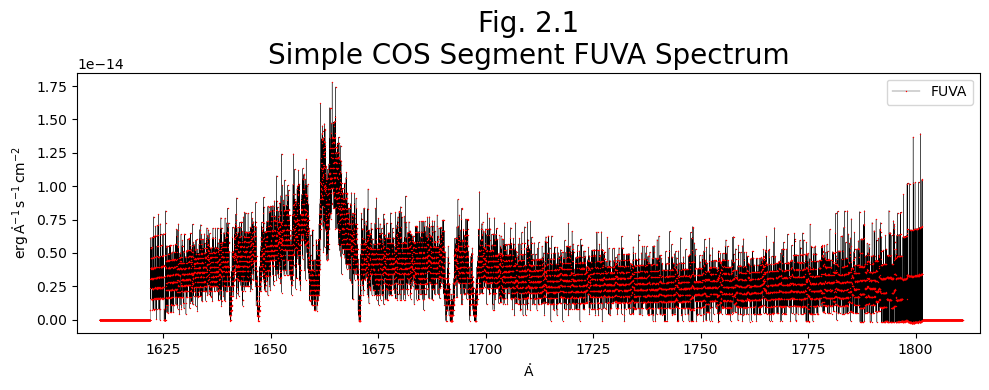

In [8]:
wvln, flux, segment  = fuv_x1d_data[0]["WAVELENGTH", "FLUX", "SEGMENT"] # 0 Accesses FUVA, the longer wvln segment and gets the data we need to plot a spectrum
wvln *= u.AA # Adds unit to the wvln of Aangstroms
flux *= u.erg/( u.second *u.AA * (u.cm)**2) # Adds unit to the flux of erg / (Angstrom cm2 s)

with quantity_support(): # Allows us to view the units attached to the data as the axes labels. This isn't generally necessary unless you want the unit support.
    
    fig1, ax = plt.subplots(1,1,figsize=(10,4), dpi = 100)  # Sets up the plot as a single box with size of 10x4 inches, and with a dpi of 100, relavent should we choose to save it
    
    # The next few lines are the core of the cell, where we actually place the data onto the plot:
    ###############
    ax.plot(wvln, flux, # First two arguments are assumed to be the x-data, y-data
            linestyle = "-", linewidth = 0.25, c = 'black', # These parameters specify the look of the connecting line
            marker = '.', markersize = 2, markerfacecolor = 'r', markeredgewidth = 0, # The marker parameters specify how the data points will look - if you don't want dots set marker = ''
            label = segment) # The label is an optional parameter which will allow us to create a legend - useful when there are multiple datasets on the same plot
    
    ax.set_title("Fig. 2.1\nSimple COS Segment FUVA Spectrum", size = 20) # Adds a title of fontsize 20 points
    
    plt.xlim(1605,1815) # These two lines set the x and y bounds of the image in whatever units we are plotting in 
    plt.ylim(-1E-15, 1.85E-14)
    
    plt.legend(loc = 'upper right') # Adds a legend with the label specified in the plotting call
    plt.tight_layout() # Gets rid of blank space
    plt.savefig(plotsdir + "Fig2.1.png") # Optionally you can save the plot as an image
    plt.show() # Shows all the plot calls in this cell and "clears" the plotting space - must come after any saving you want to do

### Exercise 2.1
Plot the data from Segment FUVB, similar to the Segment FUVA plot above, but this time, normalize flux to a max of 1, and don't plot those distracting red markers!

Note what can you simply copy over, and what you have to make sure to change.

In [9]:
# Your code here




#### Now that we have an idea for how `matplotlib` works, let's make a more complicated graph showing both FUV segments - *independently and together*.

One of the most important steps to creating a plot is planning out how it will look and convey its information - so let's start out by planning this out below:

|Panel|Contents|Information Conveyed|Notes|
|-|-|-|-|
|*top*|Entire FUV Spectrum as a **simple plot**|Overview of the entire spectrum we have, course look without much detail|Color by segment|
|*middle*|Shorter Wavelength FUVB Spectrum as an **errorbar plot**|Closer look at the shorter wavelength spectrum with an idea of error|Color errorbar by segment, central line in black|
|*bottom*|Longer Wavelength FUVA Spectrum as an **errorbar plot**|Closer look at the longer wavelength spectrum with an idea of error|Color errorbar by segment, central line in black|

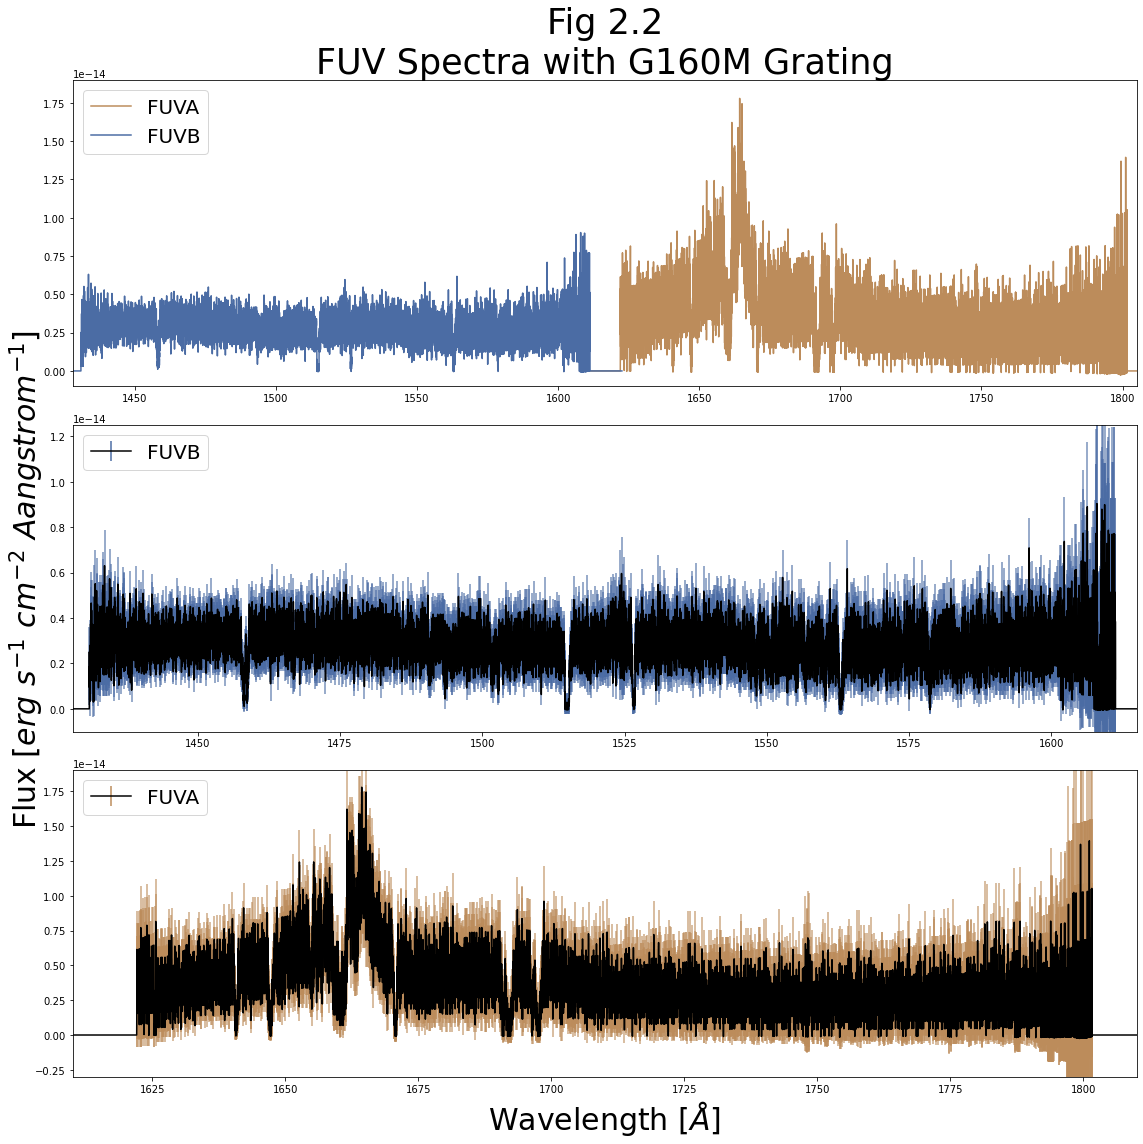

In [10]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize = (16, 16)) # ax0, ax1, ax2 are our 3 panels: top, middle, and bottom

for i in range(2): # Repeats for i = [0,1] to apply to each segment's data at a time
    wvln, flux, fluxErr, segment = fuv_x1d_data[i]["WAVELENGTH", "FLUX", "ERROR", "SEGMENT"] # Grabs all useful data for the chosen segment
    
    # This section applies to the top panel:
    ax0.plot(wvln, flux,
                linestyle = "-", label = segment, c = segment_colors[segment])
    ax0.legend(fontsize = 20 , loc = 'upper left')
    ax0.set_title("Fig 2.2\nFUV Spectra with G160M Grating", size = 35)
    ax0.set_xlim(1428,1805)
    ax0.set_ylim(-1E-15,1.9E-14)

    ######
    
    if i == 0: # This indented code applies only to segment FUVA data in bottom Panel 
        markers, caps, bars = ax2.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "-",  label = segment, marker = '', markersize = 1,
                                           c = 'k', alpha = 1, ecolor = segment_colors[segment] )
        ax2.set_xlim(1610,1810)
        ax2.set_ylim(-3E-15,1.9E-14)
        ax2.legend(fontsize = 20 , loc = 'upper left')
        ax2.set_xlabel('Wavelength [$\AA$]', size = 30)
        [bar.set_alpha(0.75) for bar in bars]
        
    ######
        
    if i == 1: # This indented code applies only to segment FUVB data in middle Panel 
        markers, caps, bars = ax1.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "-",  label = segment, c = 'k', ecolor =  segment_colors[segment] )
        ax1.set_xlim(1428,1615)
        ax1.set_ylim(-1E-15,1.25E-14)
        ax1.legend(fontsize = 20 , loc = 'upper left')
        ax1.set_ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 30)
        [bar.set_alpha(0.75) for bar in bars]
    
    ######
plt.tight_layout()
plt.savefig(plotsdir + 'Fig2.2.png', dpi = 200)
plt.show()

#### Now, it's almost impossible to get any insights on small-scale details in these plots - there's simply too high a data density. Below, we'll show examples of:
- Plotting a small region around an absorption line feature.
- Plotting an entire segment's spectrum in chunks of wavelength space.

#### Let's begin with showing a region around a line, in this case, we see a sharp line around 1670 Å. 
This is around the wavelength of Al II (1670.79 Å).

Text(0.5, 1.0, 'Fig. 2.3\nZoom in on the line at 1670 $\\AA$')

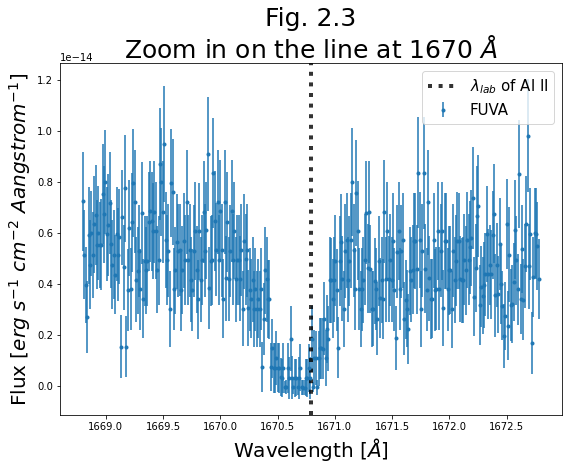

In [11]:
lineAl2 = 1670.79 #Leitherer, Claus, et al. The Astronomical Journal 141.2 (2011): 37.

wvln, flux, fluxErr, segment = fuv_x1d_data[0]["WAVELENGTH", "FLUX", "ERROR", "SEGMENT"] # Grabs all useful data for the chosen segment

wvln_extent = 2 # How many aangstroms in each direction around lineAl2 do we want to look at?

lineRegion_mask = (wvln>lineAl2 - wvln_extent) & (wvln<lineAl2 +wvln_extent) # Mask the data to within +/- wvln_extent Aangstrom of the line - this makes the plots run quicker
wvln_region, flux_region, fluxErr_region = wvln[lineRegion_mask], flux[lineRegion_mask], fluxErr[lineRegion_mask]

plt.figure(figsize=(8, 6))
plt.axvline(lineAl2, c = 'k', linewidth = 4 , linestyle = 'dotted', alpha = 0.8,  label = "$\lambda_{lab}$ of Al II")

plt.errorbar(wvln_region, flux_region, fluxErr_region, label = 'FUVA',
            linestyle = '', marker = '.')

plt.xlabel('Wavelength [$\AA$]', size = 20)
plt.ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 20)

plt.legend( fontsize = 15)
plt.tight_layout()
plt.title("Fig. 2.3\nZoom in on the line at 1670 $\AA$", size = 25)

In [450]:
(wvln>lineAl2 - wvln_extent)

array([False, False, False, ...,  True,  True,  True])

#### It's tempting to assume that because this line is close to a common spectral line (Al II) that it must correspond to that line...
#### But CAUTION! 
<img src=figures/warning.png width ="60" title="CAUTION!"> 
Remember the source we're looking at - the quasar 3C48. This quasar can be expected to have a substantial redshift, and indeed it does. $$z \approx 0.37$$  

Source: [Simbad](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=3c48&submit=SIMBAD+search)

Indeed, at that redshift, we see this line to be an entirely different wavelength: $\approx 1218$ Å. This is close to, and likely corresponds to, Lyman-$\alpha$ emission, rather than Al II.

##### This somewhat misleading line provides an excellent reminder to take what you know about the source into consideration.

#### Now we will create a much more complex plot, allowing us to visualize an entire segment's spectrum in fine detail
We'll split the spectrum into "chunks" of \~10 Aangstroms, and plot the chunks in a vertical series. These plots may take a minute to create.

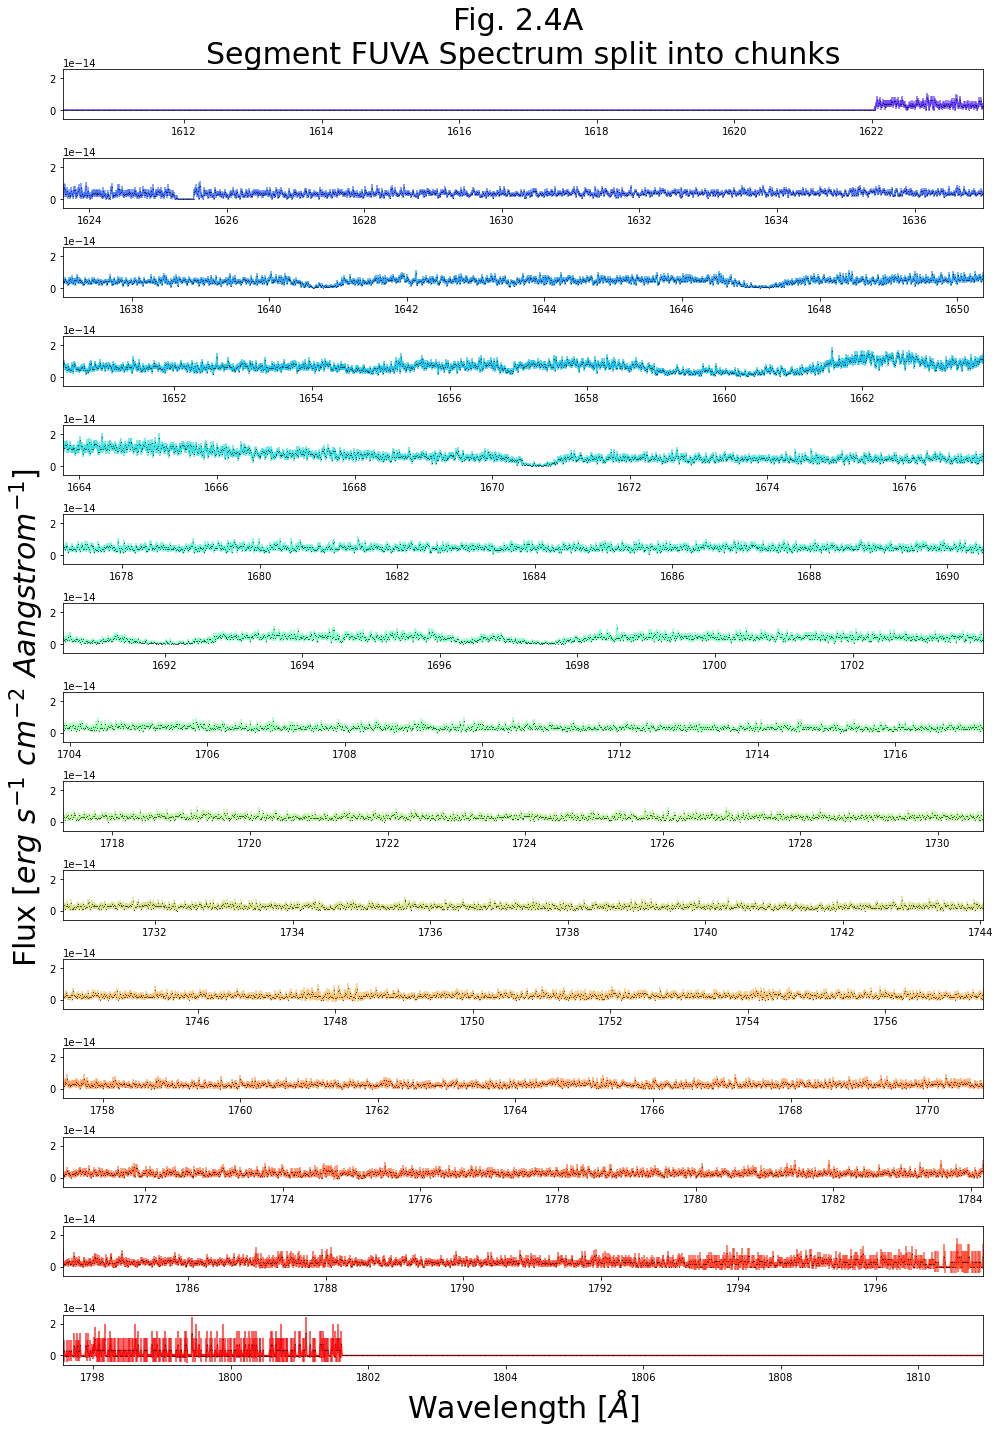


----



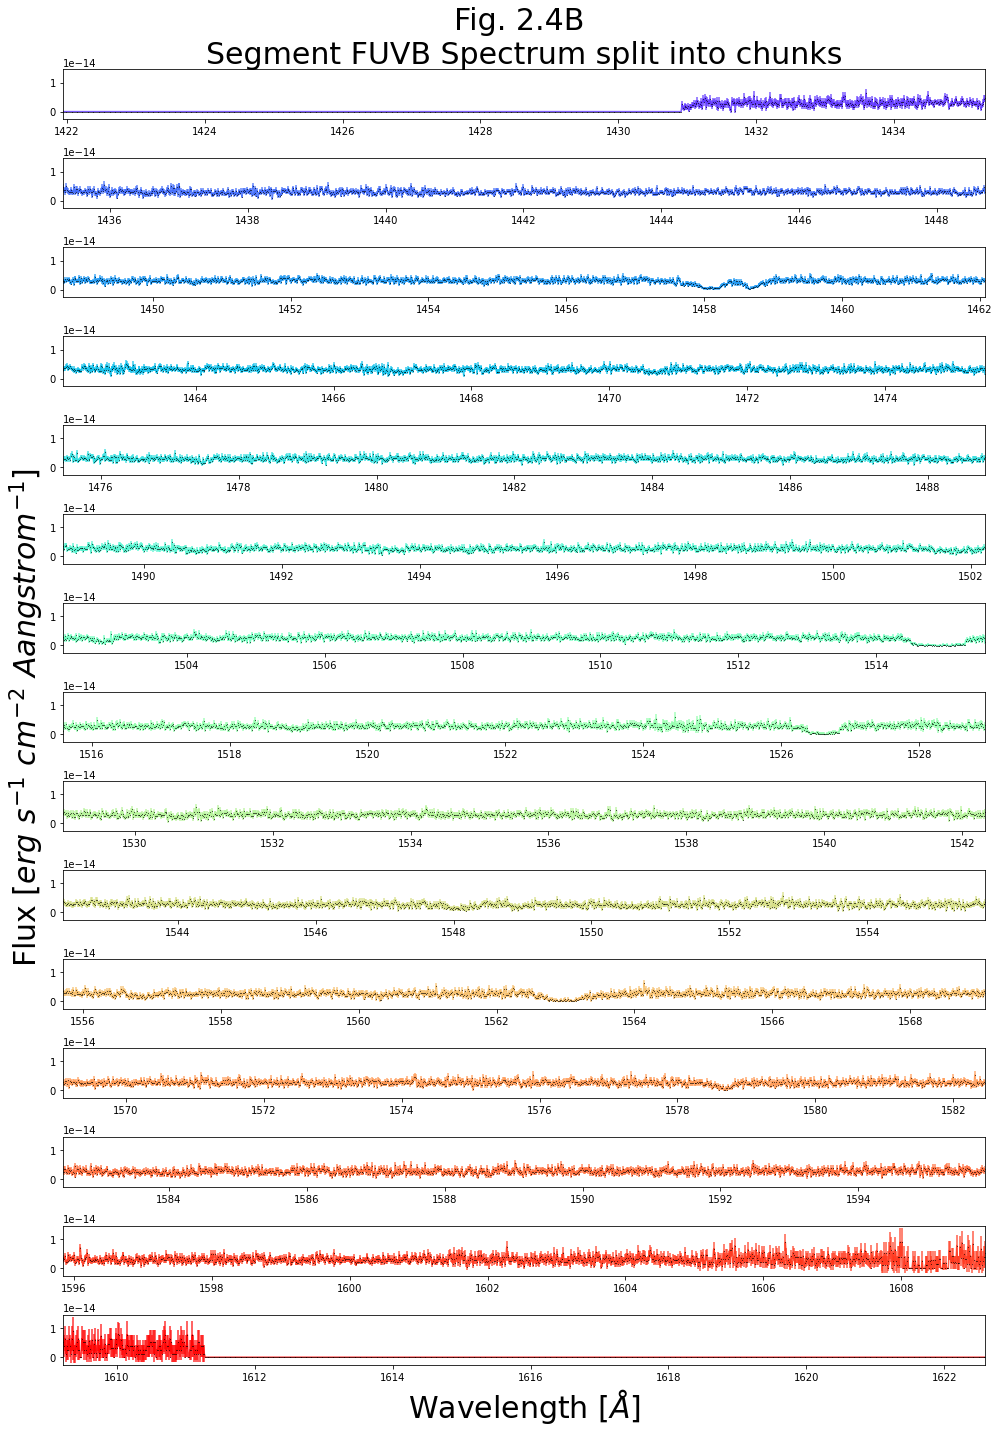


----



In [13]:
for i in range(2): # Repeats for i = [0,1] to apply to each segment's data at a time
    wvln, flux, fluxErr, segment = fuv_x1d_data[i]["WAVELENGTH", "FLUX", "ERROR", "SEGMENT"] # Grabs all useful data for the chosen segment
    
    minx, maxx = min(wvln), max(wvln)
    miny, maxy = min(flux), max(flux)
    rangex = maxx - minx
    fig = plt.figure(figsize = (14,20))

    nRows = 15 

    for i in range(nRows):
        min_ = minx + i*rangex/nRows
        max_ = minx + (i+1)*rangex/nRows
        ax = plt.subplot(nRows,1, i+1)
        
        if i == 0: # A way to set Title, xlabel, and ylabel that will work INDEPENDENT of number of rows
            ax.set_title(f"Fig. 2.4{segment[-1]} \nSegment {segment} Spectrum split into chunks", size = 30)
        if i == nRows - 1:
            ax.set_xlabel("Wavelength [$\AA$]", size = 30)
        if i == int(nRows/2):
            ax.set_ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 30)
            
            
        ax.errorbar(wvln,flux,fluxErr, c = plt.cm.rainbow((i+1)/nRows), alpha = 0.8, 
                    marker = '.', markerfacecolor = 'k', markersize = 2, mew = 0)

        ax.set_xlim(min_, max_)
    plt.tight_layout()
    plt.savefig(plotsdir + f"manyCols_seg{segment}.png", dpi = 200)
    plt.show()
    print("\n----\n")

### Exercise 2.2 Choosing and plotting a useful data range
That last plot was a bit **excessive!** Make a scaled down version from just 1600 - 1700 Aangstroms, and plot the data as a simple line graph.

In [14]:
# Your code here




### 2.2.1 Reading in the data with `specutils`

An alternative way to read in and work with spectral data is with the [`specutils` package](https://specutils.readthedocs.io/en/stable/), which contains *quite a bit of functionality* for working with spectra. It also can make dealing with units easier, as it generally works well with astropy units and other modules.

`specutils` treats spectra as python objects rather than lists, and reads in the entire spectrum over both segments. 

Below is a simple example of using `specutils` to read-in, plot, and continuum-normalize our entire spectrum.

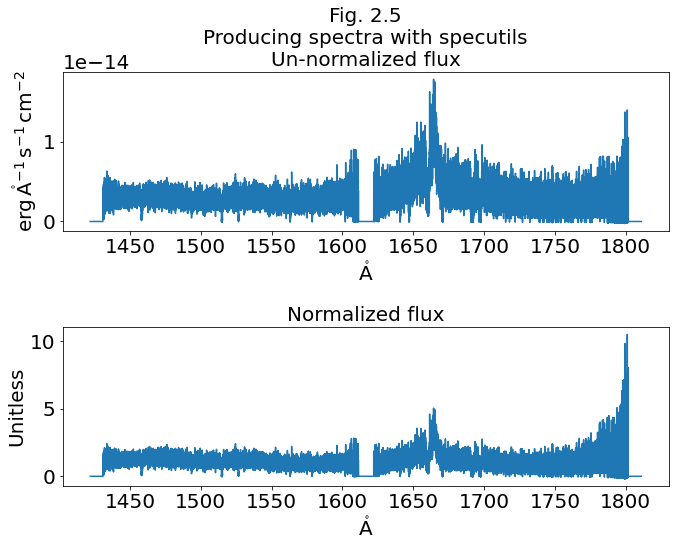

In [15]:
import specutils
from specutils.fitting import fit_generic_continuum

from matplotlib import rcParams
rcParams.update({'font.size': 20}) # The default fontsize it will use does not look good at this size

spec1d = specutils.Spectrum1D.read(fuv_x1d_filepath)

fig, (ax0,ax1) = plt.subplots(2,1,figsize = (10,8))

#Plot the non-normalized flux
ax0.plot(spec1d.spectral_axis , spec1d.flux)
ax0.set_title("Fig. 2.5\nProducing spectra with specutils\nUn-normalized flux", size = 20)

# Continuum Normalize the flux:
cont_norm_spec1d = spec1d /fit_generic_continuum(spec1d)(spec1d.spectral_axis) 

#Plot the normalized flux
ax1.plot(cont_norm_spec1d.spectral_axis , cont_norm_spec1d.flux)
ax1.set_title("Normalized flux", size = 20)
ax1.set_ylabel("Unitless")
# ax1.set_xlabel(ax2.xlabel, size = 20)

plt.tight_layout()
plt.show()

wvln, flux, fluxErr = spec1d.wavelength, spec1d.flux, spec1d.uncertainty.quantity # Not necessary for this plot, but gives us all the data separately
# segment = spec1d.meta['header']['APMPOS'][-4:] # since the spec1d contains multiple segments, it doesn't actually make sense to get this keyword; however if you need to be able to access the segment, this should work

`specutils` also works with the visualization [package `Jdaviz.Specviz`](https://github.com/spacetelescope/jdaviz), to produce very useful interactive spectral plots within a jupyter notebook GUI framework. Currently, this interactive program works well within the Jupyter Notebook environment, but not within Jupyter Lab environment. You can learn more about working with `Specviz` in our [other training here.](#NEEDS_LINK!)

## 2.2. Plotting an NUV Spectrum

The NUV data is formatted very similarly to the FUV data, and can be accessed as in [Section 1](#readInV).

In [16]:
# Here we read in the data - it is ok to ignore any warnings about slashes in the notation
nuv_x1d_data = Table.read(nuv_x1d_filepath)

### 2.2.2. Examining the first-order spectrum

#### Again, let's grab the simplest data we need to plot a spectrum: **WAVELENGTH, FLUX, and ERROR**.

We will limit this first plot to only our first order spectra (so we will exclude segment C). We will plot these two spectra together (in the top panel) and then segment-by-segment in the lower 2 panes.
- The former view gives a better sense of the continuum
- The latter views show zooms which allow us to meaningfully view the errors and see specific emission/absorption features.

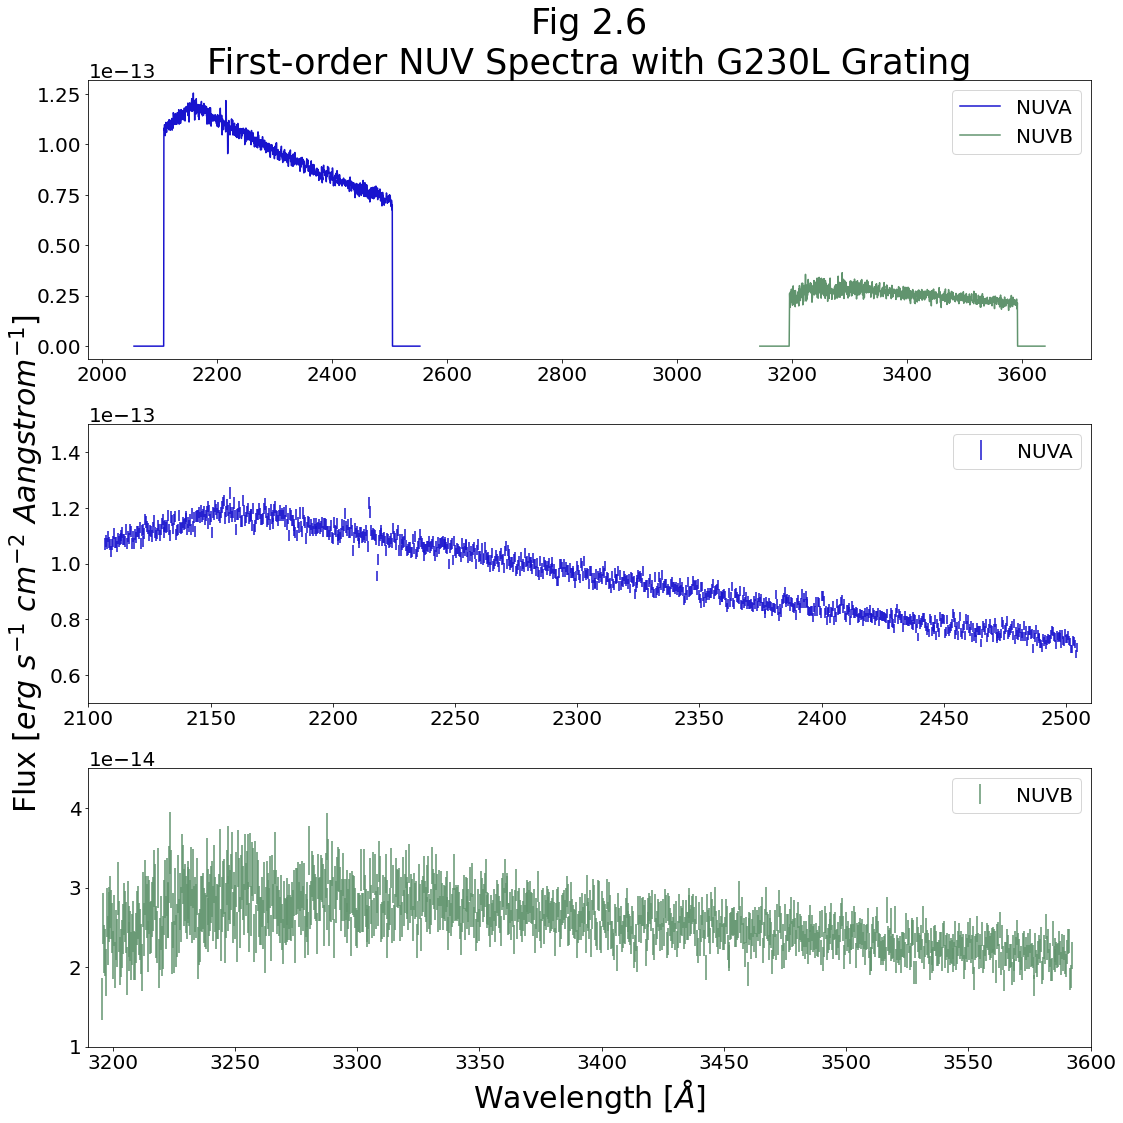

In [17]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize = (16, 16))

for i in range(2):
    wvln, flux, fluxErr, segment = nuv_x1d_data[i]["WAVELENGTH"], nuv_x1d_data[i]["FLUX"], nuv_x1d_data[i]["ERROR"], nuv_x1d_data[i]["SEGMENT"]

    ax0.plot(wvln, flux,
                linestyle = "-", label = segment, c = segment_colors[segment])
    ax0.legend(fontsize = 20 )
    ax0.set_title("Fig 2.6\nFirst-order NUV Spectra with G230L Grating", size = 35)
    
    if i == 0:
        ax1.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] )
        ax1.set_xlim(2100,2510)
        ax1.set_ylim(0.5E-13,1.5E-13)
        ax1.legend(fontsize = 20 )
        ax1.set_ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 30)
        
    if i == 1:
        ax2.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] )
        ax2.set_xlim(3190,3600)
        ax2.set_ylim(1E-14,4.5E-14)
        ax2.legend(fontsize = 20 )
        ax2.set_xlabel('Wavelength [$\AA$]', size = 30)

plt.tight_layout()
plt.show()

### 2.2.3. Examining the second-order spectrum

On segment C, we have a more dispersed spectrum over a smaller chunk of the NUV. Below, we plot this portion over the first-order spectrum from segment A.

Clearly, our errorbars on the second-order spectrum are *much larger*. However, if we need a very high dispersion, for instance, to split close-together lines, the lower panel (zoom) shows a potential advantage of segment C. Its higher spectral sampling rate allows for finer distinctions in wavelength.

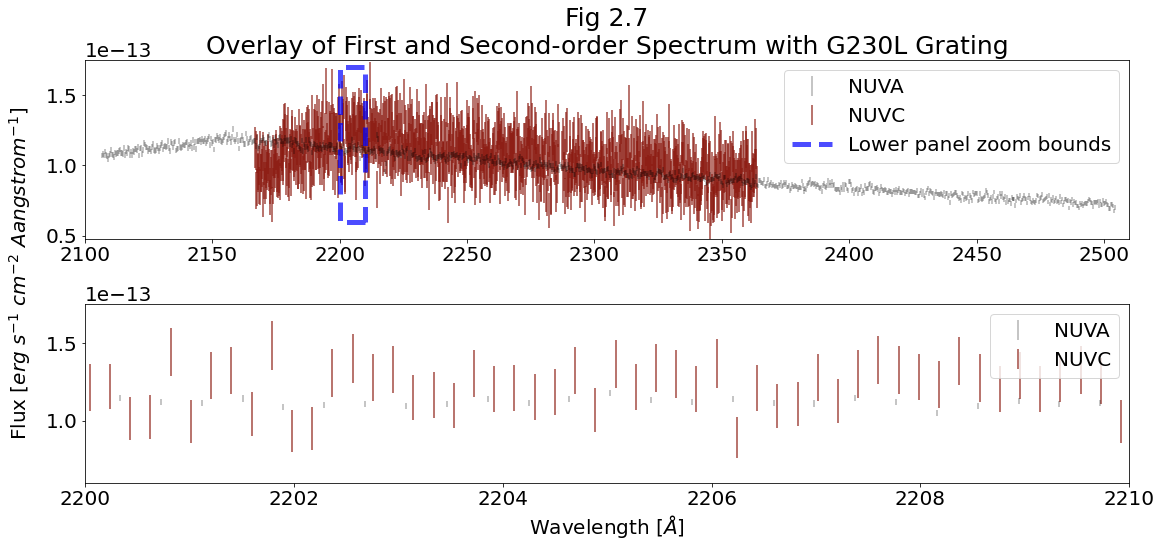

In [18]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize = (16, 8))

for i in [2,0]: #We reverse this order, so that the 0th segment (A) is plotted OVER the 2nd segment (C). It's purely aesthetic
    wvln, flux, fluxErr, segment = nuv_x1d_data[i]["WAVELENGTH"], nuv_x1d_data[i]["FLUX"], nuv_x1d_data[i]["ERROR"], nuv_x1d_data[i]["SEGMENT"]
    
    if i == 0:
        ax0.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = 'k', alpha = 0.3)
        
        ax1.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = 'k', alpha = 0.3)
        
    if i == 2:
        ax0.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] , alpha = 0.8)
        
        ax1.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] , alpha = 0.8)

 
ax0.set_xlim(2100,2510)
ax0.set_ylim(0.48E-13,1.75E-13)

ax0.set_title("Fig 2.7\nOverlay of First and Second-order Spectrum with G230L Grating", size = 25)

ax1.set_xlim(2200,2210)
ax1.set_ylim(0.6E-13,1.75E-13)

ax1.set_xlabel('Wavelength [$\AA$]', size = 20)
fig.text(-0.015, 0.5, 'Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 20, va='center', rotation='vertical')       

#Let's add a dashed rectangle to show where we are zooming into in the lower panel.
ax0.plot([2210,2200,2200,2210,2210],[0.6E-13,0.6E-13,1.7E-13,1.7E-13,0.6E-13], 
        'b', linewidth = 5, linestyle = '--', alpha = 0.7, label = "Lower panel zoom bounds")


handles,labels = ax0.get_legend_handles_labels() # These lines just ensure that the legend is ordered correctly (first ax0)
handles = [handles[2], handles[1], handles[0]]
labels = [labels[2], labels[1], labels[0]]
ax0.legend(handles, labels, fontsize = 20 , loc = 'upper right')
handles,labels = ax1.get_legend_handles_labels() # Now for ax1
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
ax1.legend(handles,labels, fontsize = 20 , loc = 'upper right')

plt.tight_layout()
plt.show()

# 3. Preliminary Review of the Data

There's no one-size-fits-all approach to analyzing COS data. 

This section aims to walk you through taking a quick but critical look at your data to assess some vital statistics, such as:
- Signal to Noise Ratio ([SNR](https://en.wikipedia.org/wiki/Signal-to-noise_ratio))
- Spectral Resolution ([R](https://en.wikipedia.org/wiki/Spectral_resolution))

as well as [binning](https://en.wikipedia.org/wiki/Data_binning) the data, for instance to the size of COS' resolution elements ([resel](https://hst-docs.stsci.edu/cosihb/chapter-3-description-and-performance-of-the-cos-optics/3-2-size-of-a-resolution-element)).

## 3.1. Initial Cleanup

One of the first things one notices in all of the plots we have made is that all of the segments have real, useful data, bookended on each size by zeros (see, for example, [Fig. 2.1](#fig2p1)).
These zeros are regions on the active area of the detector which don't receive and detect light, but *are* read in as data. We don't want these data in our spectra, so we'll filter them out. The COS data we have downloaded conveniently has an extension devoted to data quality information. Information on the data quality array and the flags it contains can be found in [Table 2.18 of the COS Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-7-error-and-data-quality-array).

Let's first look at the data quality flags. We'll do this by plotting a histogram, labelling the bins according to what the data quality value of that bin means.

/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log2
/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log2


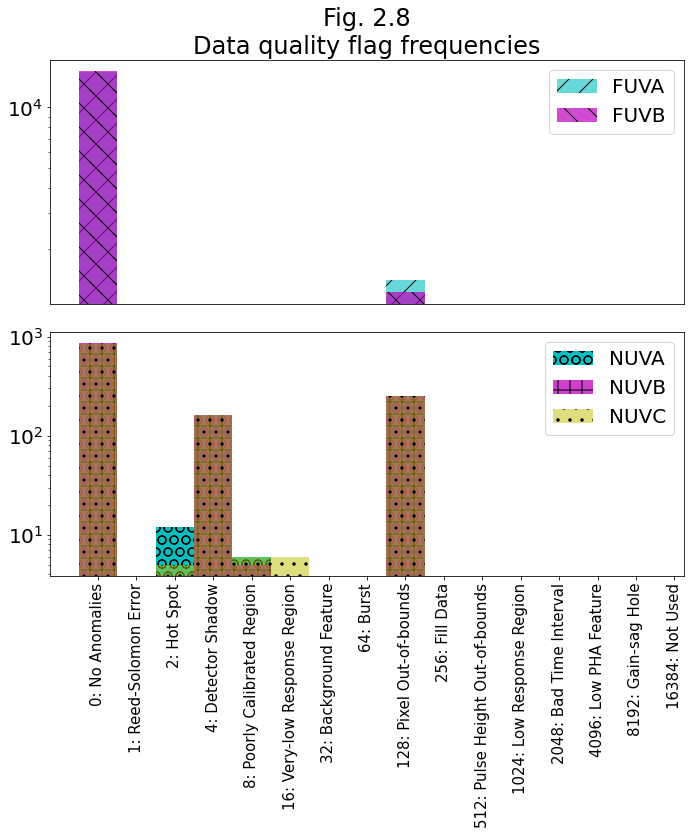

In [734]:
bins_titles = (np.logspace(-1,14, 16,base=2, dtype=int)) # The values are all powers of two from 2**1 to 2**14, except for 0, which is 2**-inf
meanings = ['No Anomalies', 'Reed-Solomon Error', 'Hot Spot', 'Detector Shadow', 'Poorly Calibrated Region', # What each power of 2 means in order
            'Very-low Response Region', 'Background Feature', 'Burst', 'Pixel Out-of-bounds', 'Fill Data', 
            'Pulse Height Out-of-bounds', 'Low Response Region', 'Bad Time Interval', 'Low PHA Feature', 
           'Gain-sag Hole', 'Not Used']

meanings2 = [str(bt)+": "+ mn for bt, mn in zip(bins_titles, meanings)]

fig, (ax0,ax1) = plt.subplots(2,1,figsize = (10,12))

for i in range(2): # First loop through the 2 FUV segments
    dataQual, segment = fuv_x1d_data[i]["DQ"], fuv_x1d_data[i]["SEGMENT"]

    bins_ = np.arange(-1,15)
    bins_titles = (np.logspace(-1,14, 16,base=2, dtype=int))

    logDQ = np.log2(dataQual)
    logDQ = np.nan_to_num(logDQ, neginf = -1)    
    
    ax0.set_xticks([])
    ax0.hist(logDQ , bins = bins_, color = 'cmy'[i], alpha =0.5+ 0.1*(i+1) , label = segment, hatch = '/\\*'[i])
    ax0.legend()
    ax0.set_yscale('log')
    ax0.set_title("Fig. 2.8\nData quality flag frequencies")

for i in range(3): # Next loop through the 3 NUV segments
    dataQual, segment = nuv_x1d_data[i]["DQ"], nuv_x1d_data[i]["SEGMENT"]

    bins_ = np.arange(-1,15)

    logDQ = np.log2(dataQual)
    logDQ[np.where(-1*(logDQ) == np.inf)] = -1

    ax1.hist(logDQ , bins = bins_, color = 'cmy'[i], alpha = 1 - 0.25*(i) , label = segment, hatch = 'O+.'[i])
    ax1.legend()
    ax1.set_yscale('log')
    
    
plt.xticks(bins_+0.5, labels = meanings2, rotation = 'vertical', fontsize = 15)
fig.set_tight_layout('tight')

Now we can pick which data quality flags we want to filter out. The only problem in the FUV and the largest problem in the NUV are pixels flagged by **"out of bounds"**, corresponding to Data Quality: **128**.

We will demonstrate removing these datapoints from the FUV data below. You could also filter to only data with *0: no anomalies*, or to any other subset.

Text(0.5, 1.0, 'Fig. 2.9\nRemoving out-of-bounds pixels')

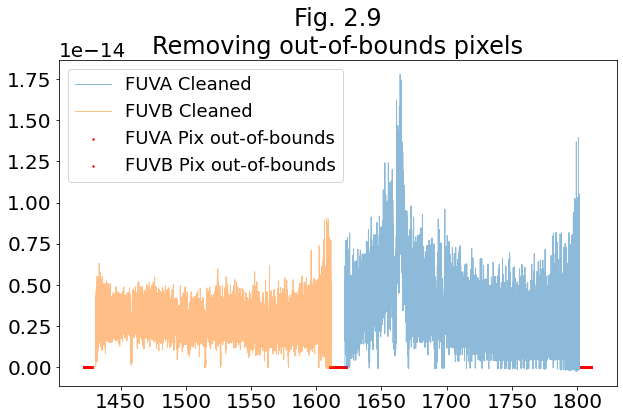

In [20]:
plt.figure(figsize = (10,6))
for i in range(2):
    wvln, flux, fluxErr, dataQual, segment = fuv_x1d_data[i]["WAVELENGTH"], fuv_x1d_data[i]["FLUX"],\
    fuv_x1d_data[i]["ERROR"], fuv_x1d_data[i]["DQ"], fuv_x1d_data[i]["SEGMENT"]


    plt.plot(wvln[dataQual != 128.0], flux[dataQual != 128.0], linewidth = 1, alpha = 0.5, 
             label = f"{segment} Cleaned")
    plt.scatter(wvln[dataQual == 128.0], flux[dataQual == 128.0], s = 2, c = 'r', alpha = 1, 
                label = f"{segment} Pix out-of-bounds")
plt.legend(fontsize = 18)
plt.title("Fig. 2.9\nRemoving out-of-bounds pixels")

### Exercise 3.1: *Removing all flagged data from the NUV*

The NUV data has flags for more than just out-of-bounds pixels.

1. Filter out all data which has been flagged
2. Plot the NUV spectrum 
3. Plot the flagged data in another color to see where the removed data is

In [21]:
# Your answer here




## 3.2. Binning 

Up until now, the data we've been working with has one value per pixel of the detector.
COS data is generally binned to a resolution element, or [resel](https://hst-docs.stsci.edu/cosihb/chapter-3-description-and-performance-of-the-cos-optics/3-2-size-of-a-resolution-element), when working with it. These resels are *generally* the following sizes *in pixels*.

||FUV|NUV|
|-|---|---|
|**Dispersion Axis**|6|3|
|**Cross-Dispersion Axis**|10|3|

So, for the FUV, we generally want to preliminarily bin x1d or x1dsum our data by 6.

In the next few cells below, we define two functions:
1. `downsample_1d`, for binning an array 
2. `binByResel`, which applies this binning to an entire COS NUV or FUV dataset

In [754]:
def downsample_1d(myarr, factor, weightsarr =[ -1], weighted = True, in_quad = False):
    """
    Downsamples a 1D array by averaging over *factor* pixels; Crops right side if the shape is not a multiple of factor; Can do in quadrature, and weighted.
    
    Parameters:
    myarr (numpy array): numpy arrayf to be downsampled/binned.
    factor (int) : how much you want to rebin the array by.
    weightsarr (numpy array) : numpy array by which to weight the average; Unnecessary if weighted == False.
    weighted (bool) : Default True. Is this an unweighted mean or a weighted average
    in_quad (bool) : Default False. Do you want to average/sum in quadrature?
    
    Returns:
    (numpy array) downsampled myarr binned by factor, cropped to an integer multiple of factor.
    
    Citation:
    Credit to Rachel Plesha for the initial inspiration on this. Rachel cited "Adam Ginsburg's python codes".
    """        
    if in_quad:
        myarr = np.power(myarr, 2)
        
    xs = myarr.shape[0]
    crop_arr = myarr[:xs-(xs % int(factor))]
    crop_weights = weightsarr[:xs-(xs % int(factor))]
    
    if weighted == True:
        if np.mean(weightsarr) == -1:
            print("CAUTION!!!! You didn't specify what to weight by!")
            dsarr = -1
        else:
            dsarr = np.average( np.concatenate(
                             [[crop_arr[i::factor] for i in range(factor)] ]
                             ),weights = np.concatenate(
                             [[crop_weights[i::factor] for i in range(factor)] ]
                             ) ,axis=0)
        
    else: # when weighted == False:
        dsarr = np.mean( np.concatenate(
            [[crop_arr[i::factor] for i in range(factor)] ]
            ),axis=0)
    if in_quad:
        dsarr = np.sqrt(dsarr)
    return dsarr

In addition to reading through this first function `downsample_1d`, we can learn about it by calling the python function `help`:

In [755]:
help(downsample_1d)

Help on function downsample_1d in module __main__:

downsample_1d(myarr, factor, weightsarr=[-1], weighted=True, in_quad=False)
    Downsamples a 1D array by averaging over *factor* pixels; Crops right side if the shape is not a multiple of factor; Can do in quadrature, and weighted.
    
    Parameters:
    myarr (numpy array): numpy arrayf to be downsampled/binned.
    factor (int) : how much you want to rebin the array by.
    weightsarr (numpy array) : numpy array by which to weight the average; Unnecessary if weighted == False.
    weighted (bool) : Default True. Is this an unweighted mean or a weighted average
    in_quad (bool) : Default False. Do you want to average/sum in quadrature?
    
    Returns:
    (numpy array) downsampled myarr binned by factor, cropped to an integer multiple of factor.
    
    Citation:
    Credit to Rachel Plesha for the initial inspiration on this. Rachel cited "Adam Ginsburg's python codes".



#### We see that the function can optionally (1) average a given bin's in quadrature and/or (2) weight the averages by a value.
1. Working in quadrature is useful for dealing with errors. [Uncertainty propogration](https://en.wikipedia.org/wiki/Propagation_of_uncertainty)
2. Some pixels receive more total exposure time than their neighbors, because of how x1d and x1dsum files are created. Pixels with more exposure time should be weighted higher.

##### In the next cell, we define a function, `binByResel`, that applies this downsampling selectively to all the data we have read in from a single COS x1dsum file.

In [757]:
def binByResel(data_table , binsize = 6, weighted = True, verbose = True):
    """
    Bins an entire COS dataset (in astropy Table form); does errors in quadrature; weights averages by a pixel's exposure time.
    
    Parameters:
    data_table (Table) : Astropy Table of COS spectral data.
    binsize (int) : What to bin by. 
    weighted (bool) : Whether to weight the averages; Default is True.
    verbose (bool) : Whether to print major steps the function is taking; Default is True.
    
    Returns:
    Table : New binned table of values
    """
    exptimes_ = []
    wvlns_, fluxs_, fluxErrs_, fluxErr_lowers_, gross_s_, gcount_s_ = [], [], [], [], [], []
    
    print(f"function `BinByResel` is Binning by {binsize}")
    for i in range(len(data_table)):
        exptimes_.append(data_table[i]['EXPTIME'])
        wvln_, flux_, fluxErr_,fluxErr_lower_, gross_, gcount_ = data_table[i][
            'WAVELENGTH', 'FLUX', 'ERROR', 'ERROR_LOWER', 'GROSS', 'GCOUNTS']
        if weighted == True:
            weightsarr_ = np.nan_to_num(gcount_/gross_, nan = 1E-30) # Exposure time can be calculated by gross counts divided by gross counts/second
                                                                      # Dividing this way results in NaNs which are messy. replace nans with a value << exptime
                                                                       # This way, weight is ~0 unless all values in a chunk are NaN
            wvln_ = downsample_1d(myarr = wvln_, weightsarr = weightsarr_, factor = binsize)
            flux_ = downsample_1d(myarr = flux_, weightsarr = weightsarr_, factor = binsize)
            fluxErr_ = downsample_1d(myarr = fluxErr_, weightsarr = weightsarr_, factor = binsize, in_quad = True) # Errors are summed/averaged in quadrature
            fluxErr_lower_ = downsample_1d(myarr = fluxErr_lower_, weightsarr = weightsarr_, factor = binsize, in_quad = True)
            gross_ = downsample_1d(myarr = gross_, weightsarr = weightsarr_, factor = binsize)
            gcount_ = downsample_1d(myarr = gcount_, weightsarr = weightsarr_, factor = binsize)

        elif weighted == False:
            weightsarr_ = -1
            
            wvln_ = downsample_1d(myarr = wvln_, weighted = False, factor = binsize)
            flux_ = downsample_1d(myarr = flux_, weighted = False, factor = binsize)
            fluxErr_ = downsample_1d(myarr = fluxErr_, weighted = False, factor = binsize, in_quad = True)
            fluxErr_lower_ = downsample_1d(myarr = fluxErr_lower_, weighted = False, factor = binsize, in_quad = True)
            gross_ = downsample_1d(myarr = gross_, weighted = False, factor = binsize)
            gcount_ = downsample_1d(myarr = gcount_, weighted = False, factor = binsize)
            
        wvlns_.append(wvln_)
        fluxs_.append(flux_)
        fluxErrs_.append(fluxErr_)
        fluxErr_lowers_.append(fluxErr_lower_)
        gross_s_.append(gross_)
        gcount_s_.append(gcount_)
        
    return Table([exptimes_,wvlns_, fluxs_, fluxErrs_, fluxErr_lowers_, gross_s_, gcount_s_], names=['EXPTIME', 'WAVELENGTH', 'FLUX', 'ERROR', 'ERROR_LOWER', 'GROSS', 'GCOUNTS'])

In [758]:
help(binByResel)

Help on function binByResel in module __main__:

binByResel(data_table, binsize=6, weighted=True, verbose=True)
    Bins an entire COS dataset (in astropy Table form); does errors in quadrature; weights averages by a pixel's exposure time.
    
    Parameters:
    data_table (Table) : Astropy Table of COS spectral data.
    binsize (int) : What to bin by. 
    weighted (bool) : Whether to weight the averages; Default is True.
    verbose (bool) : Whether to print major steps the function is taking; Default is True.
    
    Returns:
    Table : New binned table of values



#### `binByResel` gives us a new table where all of the data is sensibly binned, such that errors are summed in quadrature, and each pixel's values are weighted by their exposure time.

Below we bin our FUV data by 6. Our resulting table is just under $\dfrac{1}{6}$ the size of our input table, as a few of the last datapoints were cropped.

In [779]:
binned_fuv_data = binByResel(fuv_x1d_data)
print(f"\nOriginal Dataset Length is {len(fuv_x1d_data[0]['WAVELENGTH'])}")
print(f"Binned   Dataset Length is {len(binned_fuv_data[0]['WAVELENGTH'])}")
print(f"\t{len(fuv_x1d_data[0]['WAVELENGTH'])} over {len(binned_fuv_data[0]['WAVELENGTH'])} = {len(fuv_x1d_data[0]['WAVELENGTH'])/len(binned_fuv_data[0]['WAVELENGTH'])}\n")
binned_fuv_data

function `BinByResel` is Binning by 6


/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide



Original Dataset Length is 16384
Binned   Dataset Length is 2730
	16384 over 2730 = 6.0014652014652015



EXPTIME,WAVELENGTH [2730],FLUX [2730],ERROR [2730],ERROR_LOWER [2730],GROSS [2730],GCOUNTS [2730]
float64,float64,float32,float32,float32,float32,float32
6532.512,1610.2714700565607 .. 1810.8652436074628,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0
6532.512,1421.977067212425 .. 1622.5162032453686,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0


# 3.3. Estimating the Signal-to-Noise (SNR) Ratio

In [712]:
def estimate_SNR(data_table, snr_range = [-1, -1],  bin_data_first = False, binsize_ = 6, verbose = True):
    """
    Gets an estimate of the Signal to Noise Ratio (SNR), either over wvln-range or whole spectrum.
    data_table (Astropy Table) : astropy table of COS data.
    snr_range (list) : list of two values - [wvln_range_start , wvln_range_end]; Default is [-1,-1], indicating that we will take over all values.
    bin_data_first (bool) : Should we begin by binning the data by the binsize_? Default is False.
    binsize_ (int) : If bin_data_first == True, what to bin by; Default is 6 for fuv resel.
    verbose (bool) : Whether to give a few print statements; default is True.
    """
    snr_array = [] # Initialize to empty array
    weight_avg_snr = -1 # Will return -1 UNLESS changed
    
    # STEP ONE - BINNING
    if bin_data_first == True: # Should we bin first?
        if verbose:
            print("First, Binning the data by ", binsize_)
        data_table = binByResel(data_table , binsize = binsize_)

    # STEP TWO - ESTIMATE SNR
    for i in range(len(data_table)):
        wvln_, gross_, gcount_ = data_table[i]['WAVELENGTH', 'GROSS', 'GCOUNTS']

        if snr_range == [-1,-1]: # No range specified - estimates over the whole range
            snr_array.append([wvln_ , np.sqrt(gcount_), i])
            if verbose:
                print("No range specified.")

        else:
            if ((snr_range[0] > min(wvln_)) & (snr_range[1] < max(wvln_))):
                
                wvln_range_mask = (wvln_ > snr_range[0]) & (wvln_ < snr_range[1])

                wvln_range, gcount_range, gross_range = \
                wvln_[wvln_range_mask], gcount_[wvln_range_mask], gross_[wvln_range_mask]
                
                snr_array.append([wvln_range, np.sqrt(gcount_range), i])
                
                weight_avg_snr = np.average(np.sqrt(gcount_range), weights = np.nan_to_num(gcount_range/gross_range, nan = 1E-30))
                if verbose:
                    print(f"In range on {i}-th segment with limits:", min(wvln_), max(wvln_),
                          f"\nEXPTIME weighted average SNR over the range {snr_range} is: {weight_avg_snr}")
            else:
                snr_array.append([-1,-1,-1])
                if verbose:
                    print(f"Out of range on {i}-th segment with limits:", min(wvln_), max(wvln_))
    return weight_avg_snr, snr_array

Out of range on 0-th segment with limits: 2054.8315243832803 2552.373787783347
In range on 1-th segment with limits: 3144.0786174604305 3640.2874201030495 
EXPTIME weighted average SNR over the range [3260, 3300] is: 13.06688117980957
Out of range on 2-th segment with limits: 2141.1875695707695 2387.5891472875346
First, Binning the data by  3


/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Out of range on 0-th segment with limits: 2055.2227946721123 2551.202543205818
In range on 1-th segment with limits: 3144.4680068817165 3639.1168209501548 
EXPTIME weighted average SNR over the range [3260, 3300] is: 13.067560195922852
Out of range on 2-th segment with limits: 2141.381207452109 2387.0087020695464


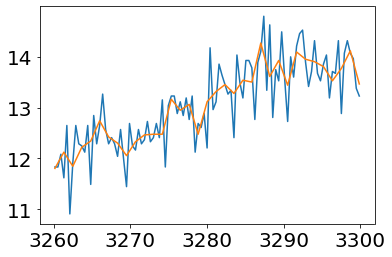

In [727]:
ee,t = estimate_SNR(nuv_x1d_data, bin_data_first=False, binsize_=3, snr_range = [3260,3300])
plt.plot(t[1][0], t[1][1])
ee,t = estimate_SNR(nuv_x1d_data, bin_data_first=True, binsize_=3, snr_range = [3260,3300])
plt.plot(t[1][0], t[1][1])

In [728]:
ee, t

(13.06756,
 [[-1, -1, -1],
  [array([3260.14482419, 3261.3135639 , 3262.48230931, 3263.65106048,
          3264.8198174 , 3265.98858004, 3267.15734842, 3268.32612256,
          3269.49490242, 3270.66368801, 3271.83247938, 3273.00127643,
          3274.17007927, 3275.33888785, 3276.50770214, 3277.67652219,
          3278.84534796, 3280.01417949, 3281.18301676, 3282.35185976,
          3283.5207085 , 3284.68956299, 3285.85842321, 3287.02728918,
          3288.19616087, 3289.36503831, 3290.53392149, 3291.70281041,
          3292.87170507, 3294.04060548, 3295.20951162, 3296.3784235 ,
          3297.54734112, 3298.71626448, 3299.88519358]),
   array([11.803954, 12.124356, 11.846237, 12.220202, 12.342339, 12.741011,
          12.423097, 12.301762, 12.055428, 12.328828, 12.463279, 12.476645,
          12.476645, 13.165611, 12.948617, 13.063946, 12.476645, 13.114877,
          13.316657, 13.453625, 13.279056, 13.540063, 13.503086, 14.271183,
          13.613719, 13.928389, 13.441231, 14.094916

/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


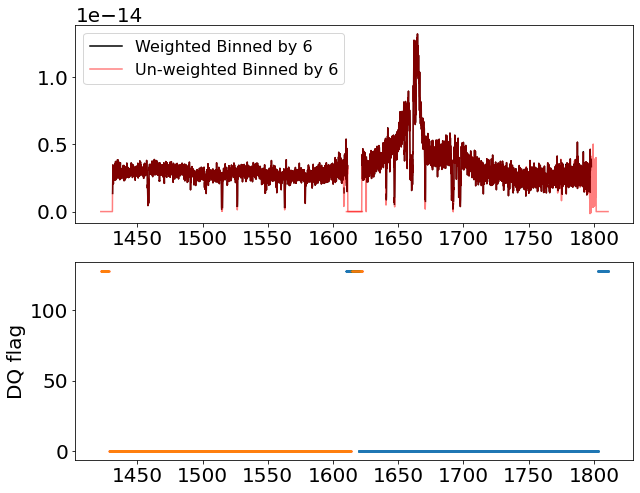

In [625]:
fig, (ax0,ax1) = plt.subplots(2, 1,figsize = (10, 8))

for i in range(2):
    weighted_binned_flux = downsample_1d(myarr = fuv_x1d_data[i]["FLUX"], weightsarr = (fuv_x1d_data[i]["GCOUNTS"]/fuv_x1d_data[i]["GROSS"]) , factor =  6)
    unweighted_binned_flux = downsample_1d(myarr = fuv_x1d_data[i]["FLUX"] , weighted = False, factor =  6)

    ###
    if i == 0:
        ax0.plot(downsample_1d(fuv_x1d_data[i]["WAVELENGTH"], factor = 6, weighted = False),weighted_binned_flux, c = 'k', label = "Weighted Binned by 6")
        ax0.plot(downsample_1d(fuv_x1d_data[i]["WAVELENGTH"], factor = 6, weighted = False),unweighted_binned_flux, c = 'r',alpha = 0.5, label = "Un-weighted Binned by 6")

    else:
        ax0.plot(downsample_1d(fuv_x1d_data[i]["WAVELENGTH"], factor = 6, weighted = False),weighted_binned_flux, c = 'k')
        ax0.plot(downsample_1d(fuv_x1d_data[i]["WAVELENGTH"], factor = 6, weighted = False),unweighted_binned_flux, c = 'r',alpha = 0.5)

        
        
    ax0.legend(fontsize = 16)

    ax1.scatter(fuv_x1d_data[i]["WAVELENGTH"], fuv_x1d_data[i]["DQ"], s = 0.5, alpha = (1 - 0.9*i))
    ax1.set_ylabel("DQ flag")

/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


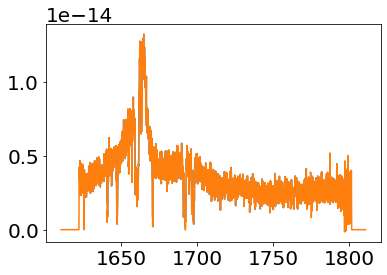

In [432]:
uw_wvln, uw_flux = binByResel(fuv_x1d_data, weighted = True)[0]["WAVELENGTH", "FLUX"]
w_wvln, w_flux = binByResel(fuv_x1d_data, weighted = False)[0]["WAVELENGTH", "FLUX"]
plt.plot(uw_wvln, uw_flux)
plt.plot(w_wvln, w_flux)

In [446]:
np.nanmin([1,2,3, np.nan, 100]), min([1,2,3, np.nan, 100])

(1.0, 1)

/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'SNR')

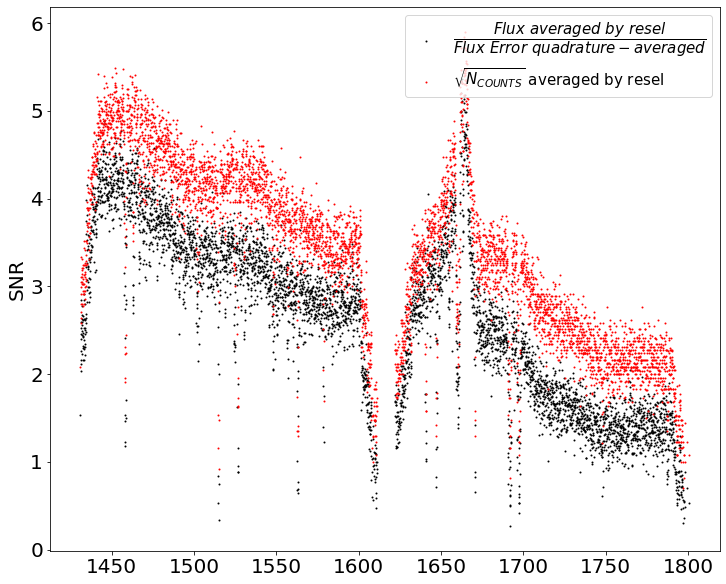

In [439]:
table_ = binByResel(fuv_x1d_data, binsize=6)
plt.figure(figsize = (12,10))
for i in range(len(table_)):
    if i == 0:
        plt.scatter(table_[i]["WAVELENGTH"], table_[i]["FLUX"]/table_[i]["ERROR"],
                   s = 1, c = 'k', label = "$\dfrac{Flux\ averaged\ by\ resel}{Flux\ Error\ quadrature-averaged}$")

        rtCts = np.sqrt(table_[i]['GCOUNTS'])
        plt.scatter(table_[i]["WAVELENGTH"], rtCts,
                   s = 1, c = 'r', label = '$\sqrt{N_{COUNTS}}$ averaged by resel')
    else:
        plt.scatter(table_[i]["WAVELENGTH"], table_[i]["FLUX"]/table_[i]["ERROR"],
                   s = 1, c = 'k')

        rtCts = np.sqrt(table_[i]['GCOUNTS'])
        plt.scatter(table_[i]["WAVELENGTH"], rtCts,
                   s = 1, c = 'r')
        
plt.legend(loc = 'upper right', fontsize = 15)
plt.ylabel("SNR")

/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/Users/nkerman/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5, 0, 'Wavelength [$\\AA$]')

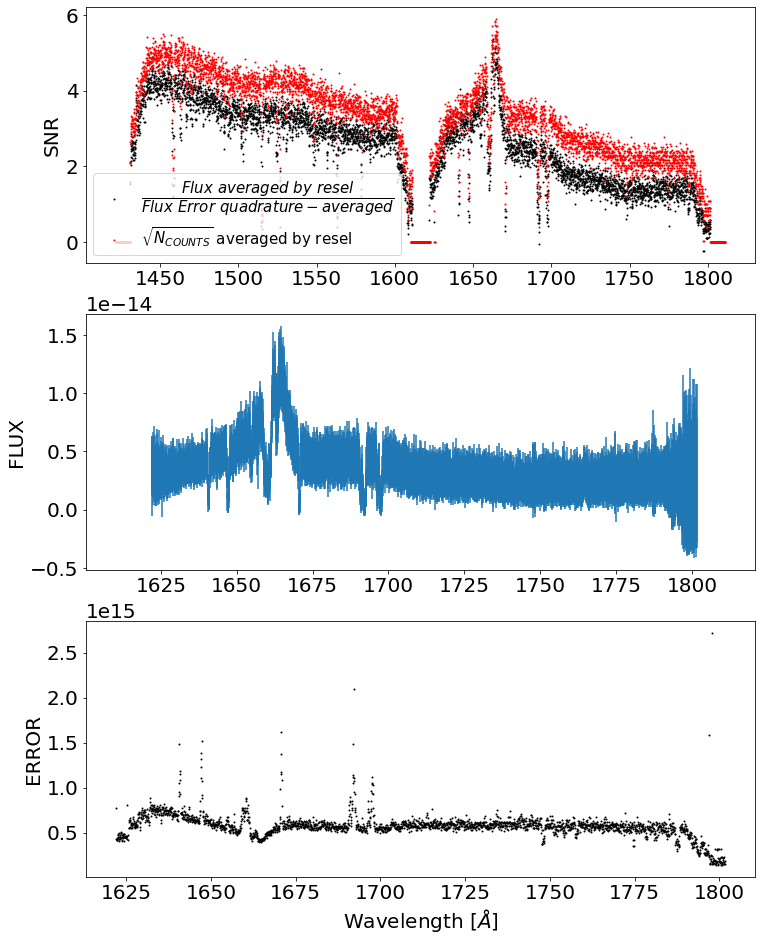

In [311]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1,figsize = (12, 16))

for i in range(len(table_)):
    if i == 0:
        ax0.scatter(table_[i]["WAVELENGTH"], table_[i]["FLUX"]/table_[i]["ERROR"],
                   s = 1, c = 'k', label = "$\dfrac{Flux\ averaged\ by\ resel}{Flux\ Error\ quadrature-averaged}$")

        rtCts = np.sqrt(table_[i]['GCOUNTS'])
        ax0.scatter(table_[i]["WAVELENGTH"], rtCts,
                   s = 1, c = 'r', label = '$\sqrt{N_{COUNTS}}$ averaged by resel')
    else:
        ax0.scatter(table_[i]["WAVELENGTH"], table_[i]["FLUX"]/table_[i]["ERROR"],
                   s = 1, c = 'k')

        rtCts = np.sqrt(table_[i]['GCOUNTS'])
        ax0.scatter(table_[i]["WAVELENGTH"], rtCts,
                   s = 1, c = 'r')
        

ax1.errorbar(table_[0]["WAVELENGTH"],table_[0]["FLUX"],table_[0]["ERROR"],
             linestyle = "")

ax2.scatter(table_[0]["WAVELENGTH"],1/table_[0]["ERROR"],
           s = 1, c = 'k')

ax0.legend(fontsize = 15)
ax0.set_ylabel("SNR")
ax1.set_ylabel("FLUX")
ax2.set_ylabel("ERROR")
ax2.set_xlabel("Wavelength [$\AA$]")


(array([ 23.,  21.,  28.,  40.,  52.,  76.,  86., 118., 150., 140., 143.,
         77.,  31.,  12.,   3.]),
 array([ 0.02340951,  0.7835423 ,  1.5436751 ,  2.30380789,  3.06394068,
         3.82407348,  4.58420627,  5.34433906,  6.10447185,  6.86460465,
         7.62473744,  8.38487023,  9.14500303,  9.90513582, 10.66526861,
        11.42540141]),
 <BarContainer object of 15 artists>)

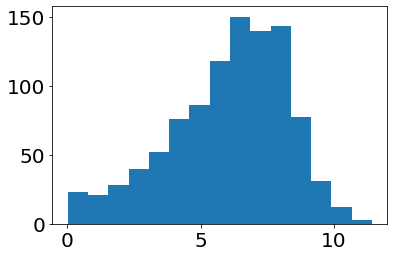

In [42]:
list1 = []
num = 1000
for i in range(1000):
    s = np.full(num , 100) + 0 * np.random.rand(num)
    n = 2*np.random.rand(num)
    initialSNR = np.mean(s/n)

    ssum = np.sum(s)
    nqsum = np.sqrt(np.sum(np.power(n, 2)))
    finalSNR = ssum/nqsum

    list1.append(finalSNR/initialSNR)
plt.hist(np.array(list1), bins = 15)

## Congratulations! You finished this notebook!
### There are more COS data walkthrough notebooks on different topics. You can find them [here](https://github.com/nkerman/Walkthroughs)


---
## About this Notebook
**Author:** [Nat Kerman](nkerman@stsci.edu)
**Updated On:** 2020-10-06

>*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*>*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topV)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 



<br></br>
<br></br>
<br></br>
# Any miscellaneous cells/quick hacks/ exercise solutions below:

In [272]:
qqq = Observations.query_criteria(proposal_id = 14910)
pl = Observations.get_product_list(qqq)
datafile_new = pl[ pl['productFilename'] == 'ldel05050_x1dsum.fits']
Observations.download_products(datafile_new)

fuv_x1d_data_new = Table.read('./mastDownload/HST/ldel05050/ldel05050_x1dsum.fits')
fuv_x1d_data_new

INFO: Found cached file ./mastDownload/HST/ldel05050/ldel05050_x1dsum.fits with expected size 927360. [astroquery.query]


INFO:astropy:Found cached file ./mastDownload/HST/ldel05050/ldel05050_x1dsum.fits with expected size 927360.


SEGMENT,EXPTIME,NELEM,WAVELENGTH [16384],FLUX [16384],ERROR [16384],ERROR_LOWER [16384],GROSS [16384],GCOUNTS [16384],VARIANCE_FLAT [16384],VARIANCE_COUNTS [16384],VARIANCE_BKG [16384],NET [16384],BACKGROUND [16384],DQ [16384],DQ_WGT [16384]
,s,,Angstrom,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),ct / s,ct / s,ct,ct,ct,ct,ct / s,ct / s,,
bytes4,float64,int32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32
FUVA,2030.816,16384,1597.4933500331272 .. 1798.1977397405144,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0


## 3.3. Reading in and plotting with `specutils`
### *(Optional)*
An alternative way to read in spectral data is with the [`specutils` package](https://specutils.readthedocs.io/en/stable/), which contains quite a bit of functionality for working with spectra. It also can make dealing with units easier, as it works well with astropy units and other modules.

Below is a simple example of using `specutils` to read-in, plot, and continuum-normalize our spectrum.

In [ ]:
import specutils
from specutils.fitting import fit_generic_continuum
spec1d = specutils.Spectrum1D.read(x1d_filepath)

fig, (ax0,ax1) = plt.subplots(2,1,figsize = (10,8))

#Plot the non-normalized flux
ax0.plot(spec1d.wavelength , spec1d.flux)
ax0.set_title("Un-normalized flux")

# Continuum Normalize the flux:
cont_norm_spec1d = spec1d /fit_generic_continuum(spec1d)(spec1d.spectral_axis) 

#Plot the normalized flux
ax1.plot(cont_norm_spec1d.wavelength , cont_norm_spec1d.flux)
ax1.set_title("Normalized flux")

plt.tight_layout()
plt.show()

<a id="downloadV"></a>
# 1. Downloading the Data

One can search for COS data from both a browser-based gui and a command-line `Python` library.

##### *A more in-depth MAST archive tutorial can be found [here](https://mast.stsci.edu/api/v0/MastApiTutorial.html).*


## 1.1 The MAST Web Search
A browser gui for searching HST archival data can be found [here](http://archive.stsci.edu/hst/search.php).

The search page is laid out as in fig. 1.1:
### Fig 1.1
<center><img src=figures/Mast_hst_searchform3.png width ="900" title="MAST Archive search form for a COS data query"> </center>

where here we have indicated we would like to find all archival data from the **COS near-ultraviolet configuration science** data, taken with the **G230L grating** while looking at **stars**. The output columns we have selected to see are visible in the bottom left of Fig 1.1.

Note that if you have a list of coordinates, Observation ID(s), etc. you can click on the "File Upload Form" and attach your list of OBSIDs or identifying features. Then specify which type of data your list contains using the "File Contents" drop-down menu.

Figure 1.2 shows the *long* results of our search.
### Fig 1.2
<center><img src=figures/mast_hst_searchRes.png width ="900" title="MAST Archive search results for a COS data query"> </center>


#### We now choose our dataset.
We *arbitrarily* select LBBD01020, taken under an calibration program described as:
> "NUV Spectroscopic Sensitivity Monitoring"

This is a white dwarf star  known as [WD1057+719](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=WD1057%2B719&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id)

Clicking on the dataset, we are taken to a page displaying a preview spectrum (Fig 1.3).
### Fig 1.3

<center><img src=./figures/preview_spec1.png width ="900" title="MAST Archive preview spectrum of LBBD01020"> </center>

We now return to the [search page](http://archive.stsci.edu/hst/search.php) and enter in LBBD01020 under "Dataset" with no other parameters set. Hitting search, now we see a single-rowed table with just our dataset, and *crucially* the option to download datasets. We mark the row we wish to download and click "Submit marked data for retrieval from STDADS". See Fig 1.4.

### Fig. 1.4

<center><img src=figures/LBBD01020_res.png width ="900" title="MAST Archive dataset overview of LBBD01020"> </center>

Now we see a page like in Fig 1.5, where we can either sign in with STScI credentials, or simply provide our email to proceed (relatively) anonymously. Make sure to select "Deliver the data to the Archive staging area". Hit "Send Retrieval Request to STDADS" and you will recieve an email with instructions on downloading with ftp. You will need to do this step from the command line.

In the case of this request, the command to retrieve the data was:
>`wget -r --ftp-user=anonymous --ask-password ftps://archive.stsci.edu/stage/anonymous/anonymous42822 --directory-prefix=datadir`

where the password was the email address used, and datadir is the directory defined at the beginning of this notebook.. Now all the data is in a subdirectory `"/archive.stsci.edu/stage/anonymous/anonymous42822/"`

#### Well Done!


### Exercise 1: *Searching the archive for TRAPPIST-1 data*

[TRAPPIST-1](https://en.wikipedia.org/wiki/TRAPPIST-1) is a cool red dwarf with a multiple-exoplanet system. 
- Find its coordinates using the [SIMBAD Basic Search](http://simbad.u-strasbg.fr/simbad/sim-fbasic).
- Use those coordinates in the [MAST web search](https://archive.stsci.edu/hst/search.php) to find all COS exposures of the system.
- Limit the search terms to find the COS dataset taken in the COS far-UV configuration with the grating G130M.

#### What is the dataset ID, and how long was the exposure?

Place your answer in the cell below.

In [ ]:
# Your answer here



## 1.2 astroquery.mast
Another way to search for and download archived datasets is within `Python` using the module [`astroquery.mast`](https://astroquery.readthedocs.io/en/latest/mast/mast.html). We have already imported 2 of this module's key tools: `Observations` and `Mast`.

There are *many* options for searching the archive with astroquery, but we will begin with a very general search using the coordinates we found in the last section to find the same dataset. 
- Our coordinates were:      (11:00:34.126 +71:38:02.80). 
    - We can search these coordinates as sexagesimal coordinates, or convert them to decimal degrees.

In [ ]:
query_1 = Observations.query_object("11:00:34.126 +71:38:02.80", radius="5 sec")

This command has generated a table of objects called **"query_1"**. We can see what information we have on the objects in the table by printing its *`keys`*, and see how many objects are in the table with `len(query_1)`.

In [ ]:
print(f"We have table information on {len(query_1)} observations in the following categories/columns:\n")
(query_1.keys())

#### Now we narrow down a bit with some additional parameters (wavelength_region,instrument_name and configuration, dataproduct_type):

In [ ]:
query_2 = Observations.query_criteria(s_ra=[165., 166.], s_dec=[+71.,+72.],
                                        wavelength_region="UV", instrument_name="COS/NUV", 
                                        dataproduct_type = "spectrum")
query_2[:5] #NOT THE FULL TABLE!

#### Caution! 
<img src=figures/warning.png width ="60" title="MAST Archive preview spectrum of LBBD01020"> 
Please note that these queries are Astropy tables and do not always respond as expected for other data structures like Pandas DataFrames. For instance, the first way of filtering a table shown below is correct, but the second will consistently produce the *wrong result*.

In [ ]:
# Searching a table generated with a query
## First correct way using masking
mask = (query_1['obs_id'] == 'lbbd01020') # NOTE, obs_id must be lower-case
print("Correct way yields: \n" , query_1[mask]['obs_id'],"\n\n")

# Second incorrect way
print("Incorrect way yields: \n" , query_1['obs_id' == 'LBBD01020']['obs_id'])

### Now we can choose download our data products from the archive dataset.

We will first generate a list of data products in the dataset: `product_list`. Then we will download *just the* **minimum recommended products**, which are the fully calibrated spectrum (denoted by the suffix `_x1d` or here `x1dsum`) and the association file (denoted by the suffix `_asn`).

In [ ]:
product_list = Observations.get_product_list(query_2)
product_list

In [ ]:
mask_prod_list = (product_list['obs_id'] == 'lbbd01020') # only get this one observation id
downloads = Observations.download_products(product_list[mask_prod_list], download_dir=datadir , extension='fits', mrp_only=True, cache=False)
# The cache = False allows it to re-download data it still finds on the computer

### Exercise 2: *Download the raw counts data on TRAPPIST-1*

In the previous exercise, we found an observation COS took on TRAPPIST-1 system. In case you skipped Exercise 1, the observation's Dataset ID is `LDLM40010`.

Use `Astroquery.mast` to download the raw `TIME-TAG` data, rather than the x1d spectra files. See the [COS Data Handbook Ch. 2](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-4-cos-data-products) for details on TIME-TAG data files. Make sure to get the data from both segments of the FUV detector (i.e. both `RAWTAG_A` and `RAWTAG_B` files). If you do this correctly, there should be five data files for each detector segment.

*Note that some of the obs_id may appear in the table as slightly different, i.e.: ldlm40alq and ldlm40axq, rather than ldlm40010. The main obs_id they fall under is still ldlm40010, and this will still work as a search term. They are linked together by the association file described here in section 2.3.*

In [ ]:
# Your answer here




## Excellent! You've now done the hardest part - finding and downloading the data. From here, it's generally straightforward to read in and plot the spectrum.

## Exercise Solutions:

In [ ]:
## Ex. 1 soln:
dataset_id_ = 'LDLM40010'
exptime_ = 12403.904*u.s
print(f"The TRAPPIST-1 COS data is in dataset {dataset_id_}, taken with an exosure time of {exptime_}")

In [ ]:
## Ex. 2 soln:
query_3 = Observations.query_criteria(obs_id = 'LDLM40010',
                                        wavelength_region="UV", instrument_name="COS/FUV", filters = 'G130M')

product_list2 = Observations.get_product_list(query_3)
rawRowsA = np.where(product_list2['productSubGroupDescription'] == "RAWTAG_A")
rawRowsB = np.where(product_list2['productSubGroupDescription'] == "RAWTAG_B")
rawRows = np.append(rawRowsA,rawRowsB)

downloads2 = Observations.download_products(product_list2[rawRows], download_dir=datadir+'Ex2/' , extension='fits', mrp_only=False, cache=True)
downloads3 = Observations.download_products(product_list2, download_dir=datadir+'Ex2/' , extension='fits', mrp_only=True, cache=True)

asn_data = Table.read('./data/Ex2/mastDownload/HST/ldlm40010/ldlm40010_asn.fits', hdu = 1)
print(asn_data)

In [ ]:
## Ex. 3 Soln:
fig, (ax0,ax1) = plt.subplots(2,1,figsize = (16, 8))

for q in range(3):
    ax0.hist(nuv_x1d_data[q]["FLUX"], alpha = 0.5, label = nuv_x1d_data[q]["SEGMENT"], bins = np.linspace(0,1.8E-13,60))

for q in range(2):
    mask_no_zeros = (nuv_x1d_data[q]["FLUX"] != 0.0)
    ax1.plot(nuv_x1d_data[q]["WAVELENGTH"][mask_no_zeros],nuv_x1d_data[q]["FLUX"][mask_no_zeros], alpha = 0.5, label = nuv_x1d_data[q]["SEGMENT"])
    ax1.plot(nuv_x1d_data[q]["WAVELENGTH"][np.invert(mask_no_zeros)],nuv_x1d_data[q]["FLUX"][np.invert(mask_no_zeros)], linestyle = '', marker = '.' , c ='r', alpha = 0.5, label = nuv_x1d_data[q]["SEGMENT"]+" zeros")
ax0.legend()
ax0.set_title("Flux distributions", size = 30)

ax1.legend()
ax1.set_title("First-order spectrum without zeros", size = 30)

ax0.set_xlabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]\n----\n', size = 20)
ax1.set_xlabel('Wavelength [$\AA$]', size = 20)
ax1.set_ylabel('Flux\n[$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 15)

plt.tight_layout()

### Misc/Junk

In [ ]:
# mask = (query_1['obs_id'] == 'lbbd01020')
mask_prod_list2 = (product_list['obs_id'] == 'lbbd01hpq') | (product_list['obs_id'] == 'lbbd01020' )
product_list[mask_prod_list2]

In [ ]:
# mask_prod_list = (product_list['obs_id'] == 'lbbd01020') # only get this one observation id
# downloads = Observations.download_products(product_list[mask_prod_list], download_dir=datadir , extension='fits', mrp_only=True, cache=False)

In [ ]:
# plist = Observations.get_product_list(Observations.query_criteria(obs_id = 'lbbd01020'))
downloads = Observations.download_products(Observations.get_product_list(Observations.query_criteria(obs_id = 'lbbd01020')),
                                           download_dir=datadir , extension='fits', mrp_only=True, cache=False)

In [ ]:
nuv_x1d_data[q].colnames
print(nuv_x1d_data[q]["DQ"][:500])

In [ ]:
bins

In [ ]:
!git branch

In [132]:
from astropy.table import Column
a = (1, 4)
b = np.array([[2, 3, 10], [5, 6, 10]])  # vector column
c = Column(['x', 'y'], name='axis')
arr = (a, b, c)
t = Table(arr)  
t

col0,col1 [3],axis
int64,int64,str1
1,2 .. 10,x
4,5 .. 10,y


In [134]:
t["col1"][0]

array([ 2,  3, 10])